In [1]:
import numpy as np
import sympy as sym # simbolno reševanje
import matplotlib.pyplot as plt # grafi
from scipy.interpolate import interp1d # interpolacija
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D # 3-D grafi
from scipy import optimize # iskanje niče
from scipy import integrate # diferencialne enačbe
%matplotlib inline
sym.init_printing()

Avtor: **Klemen Kubelj, 23150452**

Datum: 23. maj 2017

*Potrjujem, da sem avtor projektne naloge in da sem vso vsebino pripravil sam. V primeru, da se ugotovi plagiatorstvo se zavedam, da ne bom izpolnjeval pogojev za pristop k izpitu.*

## Uvod

V sklopu tega projekta bom naredil modul za vse potrebne izračune gonila, ki ga obravnavamo pri predmetu Strojni Elementi 2. Cilj je, da bo uporabnik s pomočjo modula podal začetne podatke, nato pa klical različne metode in modul mu bo podajal željene vrednosti, risal grafe itd.

Ker je problem precej obsežen in je večinoma rešen s pomočjo objektnega programiranja, znotraj enega razreda (class-a) pa ni mogoče pisati v Markdown načinu, bom v tem poročilu predstavil le, kako so rešene vsebine, predpisane na 1. predavanjih. 
Torej:
* *simbolno reševanje*, 
* *sistemi linearnih enačb*, 
* *interpolacija ali aproksimacija*,
* *iskanje ničel*, 
* *integriranje ali odvajanje*, 
* *reševanje diferencialnih enačb*


Pri ostalih delih modula so podani Docstringi ter karseda natačni komentarji.

# Definicija naloge

Konstruirajte in vrednotite zobniško gonilo, ki bo zadostilo podanim zahtevam. Dvostopenjsko gonilo z valjastimi zobniki z ravnimi zobmi je nameščeno med gredjo elektromotorja in gredjo delovnega stroja. Gonilna gred (gred 1) prenaša moč P<sub>1</sub> in se vrti z vrtilno hitrostjo n<sub>1</sub>. Izhodna gred (gred 3) se vrti z vrtilno hitrostjo n<sub>3</sub>. Zobniki prve stopnje imajo modul m<sub>1,2</sub>, zobniki druge pa modul m<sub>3,4</sub>. Priporočena širina zobnikov znaša cca. 15 modulov. Ohišje naj ima delilno ravnino na sredini vseh ležajev.

Slika 1 iz vira [1]:<img src="slike/definicija.png">

## Zahteve

*	Določite prestavna razmerja, dejanske vrtilne hitrosti gredi, vrtilne momente na
	posameznih gredeh in moč na izhodu iz gonila.
*	Na podlagi znanih torzijskih momentov preliminarno določite premere gredi.
*	Določite dimenzije vseh zobnikov in medosne razdalje.
*	Glede na dimenzije gredi izberite kotalne ležaje in jih vgradite na gredi in v ohišje.
*	Določite sile na zobnikih, obremenitev gredi 2 ter obremenitev ležajev na gredi 2. 


# Uvoz modula in kreacija instance le-tega

Najprej je potrebno uvoziti modul ter iz razreda Gonilo ustvariti instanco razreda (objekt). Naš objekt poimenujemo Klemen, vhodni podatki pa naslednji:
	
* P<sub>1</sub> = 7500 W
* n<sub>1</sub> = 1455 min<sup>-1</sup>
* n<sub>3</sub> = 100 min<sup>-1</sup>
* m<sub>1,2</sub> = 2,5	mm
* m<sub>3,4</sub> = 4,5 mm


In [2]:
from gonilo import Gonilo
Klemen = Gonilo(7500, 1455, 100, 2.5, 4.5, z1=21, z3=21)

Že takoj lahko kličemo nekaj atributov našega objekta:

In [3]:
print('Skupno prestavno razmerje =',Klemen.isk)
print('Moč na delovnem stroju = ',Klemen.Pds)

Skupno prestavno razmerje = 14.55
Moč na delovnem stroju =  6576.508227665993


Za več primerov uporabe modula lahko gledamo help, priložena pa je tudi datoteka "proba_gonila.py", kjer je v logičnem vrstnem redu prikazana uporaba modula. Prav tako je na koncu tega notebook-a narejeno kratek povzetek modula.

# Sistemi linearnih enačb

Tema "sistemi linearnih enačb" je v modulu uporabljena za izračun reakcij vseh 3 gredi v obeh ravninah $X-Y$ in $X-Z$.
Tukaj je predstavljen potek izračuna za drugo gred v $X-Y$ ravnini.

<img src="slike/statika_gred2_XY.png">

Naši podatki so naslednji:

In [4]:
l1 = 0.063
l2 = 0.078
l3 = 0.043
Fr2 = 635.9
Fr3 = 1615

Imamo torej naslednjih sistem enačb:

$A_y + Fr_3 = B_y + Fr_2$

$Fr_2 * l_1 - Fr_3 * (l_1 + l_2)  + B_y * (l_1 + l_2 + l_3) = 0$

V tem primeru so neznanke $A_y$ in $B_y$ zato matrika koeficientov in vektor konstant izgledata tako:

In [5]:
A1 = np.array([[1, -1],
                [0, (l1 + l2 + l3)]])

b1 = np.array([Fr2 - Fr3, Fr3 * (l1 + l2) - Fr2 * l1])

In [6]:
Ay = np.linalg.solve(A1, b1)[0]
By = np.linalg.solve(A1, b1)[1]
print('Ay =',Ay,'N')
print('By =',By,'N')

Ay = 40.7548913043 N
By = 1019.8548913 N


Z uporabo modula lahko do istih rezultatov pridemo s klicanjem naslednje metode (ta nam prikladno izriše še grafe prečnih sil in upogibnih momentov):

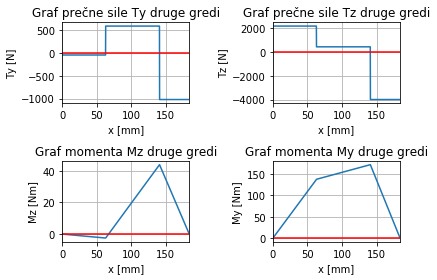

Ay = 40.7593065666 N
By = 1019.86038813 N


In [7]:
Klemen.statika_gredi_2(l1 = 63, l2 = 78, l3 = 43) #podati moramo te vhodne podatke
print('Ay =',Klemen.gred2_Ay,'N')
print('By =',Klemen.gred2_By,'N')

# Interpolacija

Interpolacija je v modulu uporabljena veliko. Tukaj bo prikazana njena uporaba za interpolacijo krivulj na naslednjem grafu.
Graf se uporablja tako, da na podlagi izbranega olja in temperature obratovanja razberemo dinamično ali kinematično viskoznost olja.

Slika 2 iz vira [1]:<img width=500 src="slike/diagram10.png" >

Če torej preberemo 8 točk za zgornjo krivuljo (olje ISO VG 1500):

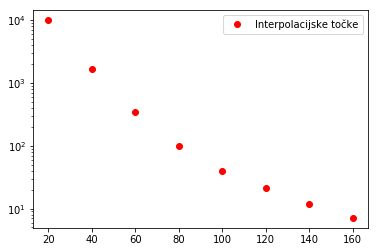

In [8]:
x1 = [20, 40, 60, 80, 100, 120, 140, 160]
y1 = [10000, 1700, 350, 100,  40, 21, 12, 7.1] #prebrani podatki

plt.plot(x1, y1, 'ro', label = 'Interpolacijske točke') #narišemo prebrane točke
plt.legend()
plt.yscale('log')

Sedaj pa je čez prebrane točke potrebno interpolirati krivuljo. To je v modulu narejeno s pomočjo funkcije interp1d iz paketa scipy.

In [9]:
funkc1 = interp1d(x1, np.log(y1), 3) #y vrednosti je potrebno logaritmirati, saj je y os logaritemska
funkc11 = lambda x: np.exp(funkc1(x)) #ker smo podatke prej logaritmirali, moramo sedaj izvesti inverno operacijo, da dobimo
                                      #pravo funkcijo

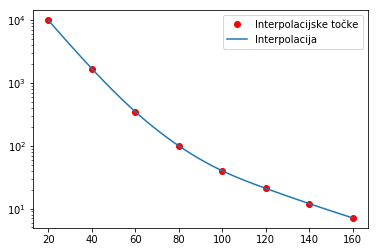

In [10]:
x_vec = np.linspace(20,160,1000) #določimo gostejše polje za izris

plt.plot(x1, y1, 'ro', label = 'Interpolacijske točke')
plt.plot(x_vec, funkc11(x_vec), label = 'Interpolacija')
plt.legend()
plt.yscale('log')

V modulu je po tem načinu narejena interpolacija za vsako olje. Lahko tudi kličemo metodo, ki nam izriže diagram.

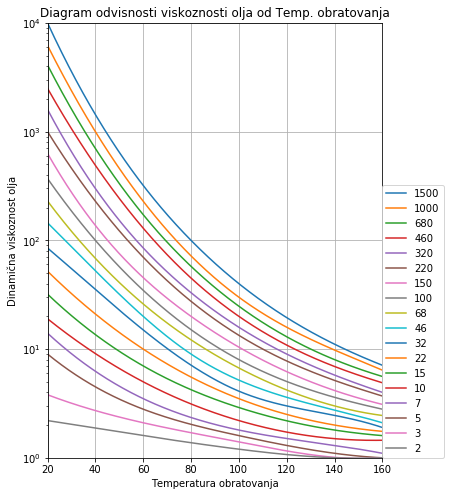

In [11]:
plt.figure(figsize=(6,8))
Klemen.diagram_10()
Klemen.diagram_10_izris()

Prav tako je narejena interpolacija za naslednji graf iz predloge:

Slika 3 iz vira [1]:<img width=500 src="slike/diagram8.png" >

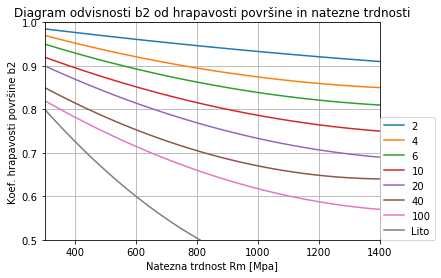

In [12]:
Klemen.diagram_8()
Klemen.diagram_8_izris()

# Numerično integriranje

Tema "numerično integriranje" je v modulu zajeta v sklopu poročila laboratorijske vaje.
Naloga je, da iz izračunanega poteka moči trenja in pospeševanje izračunamo delo, ki ga je posamezna moč opravila v času.

$W_{tr} = \int_0^{t_z} \mathrm{P_{tr}(t)}\,\mathrm{d}t$

$W_{pos} = \int_0^{t_z} \mathrm{P_{pos}(t)}\,\mathrm{d}t$

In [13]:
Klemen.LV_preberi_meritve('podatki_laboratorijska\S01meh.txt') #preberemo rezultate meritev

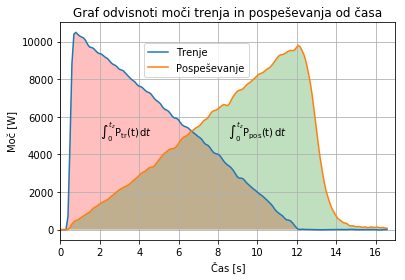

In [14]:
Klemen.LV_graf3() #izrišemo graf
plt.fill_between(Klemen.t, Klemen.Ptr, alpha=0.25, facecolor='r') #z rdečo barvo pobarvamo ploščino pod močjo trenja
plt.annotate('$\int_0^{t_z} \mathrm{P_{tr}(t)}\,\mathrm{d}t$', xy=(2, 5000))
plt.fill_between(Klemen.t, Klemen.Ppos, alpha=0.25, facecolor='g') #z zeleno barvo pobarvamo ploščino pod močjo pospeševanja
plt.annotate('$\int_0^{t_z} \mathrm{P_{pos}(t)}\,\mathrm{d}t$', xy=(8.5, 5000))

Z integriranjem torej želimo doličiti površino pod krivuljama. Ker ne poznamo funkcije poteka moči, moramo to narediti numerično.

V modulu je integracija narejena z metodo np.trapz(Ptr, t) in np.trapz(Ppos, t), ki integral računa po sestavljenem trapeznem pravilu:

In [15]:
print('Delo trenja Wtr =',Klemen.LV_Wtr,'J')
print('Delo pospeševanja Wpos =',Klemen.LV_Wpos,'J')

Delo trenja Wtr = 63306.2649986 J
Delo pospeševanja Wpos = 67692.5816167 J


Če za primerjavo integral izračunamo še po pravokotnem pravilu integriranja:

In [16]:
def int_pravokotno_pravilo(y, korak):
    """Funkcija sprejme vrednosti y in korak h ter vrne vrednost integrala."""
    return np.sum(y) * korak

In [17]:
y1 = Klemen.Ptr #podatki za moč trenja
y2 = Klemen.Ppos #podatki za moč pospeševanja
h = Klemen.t[1] #korak

In [18]:
print('Delo trenja po pravokotnem pravilu Wtr =',int_pravokotno_pravilo(y1,h),'J')
print('Delo pospeševanja po pravokotnem pravilu Wpos =',int_pravokotno_pravilo(y2,h),'J')

Delo trenja po pravokotnem pravilu Wtr = 51910.9950503 J
Delo pospeševanja po pravokotnem pravilu Wpos = 55510.9093057 J


# Simbolno reševanje

V sklopu modula simbolno reševanje ni uporabljeno, zato bom to temo pokril s problemom iz matematike.

NALOGA: Za podano funkcijo več spremenljivk, definirano kot "f" je potrebno določiti stacionarne točke ter jih klasificirati.

In [19]:
x, y, funck = sym.symbols('x y f') #definiramo simbole, ki jih bomo potrebovali

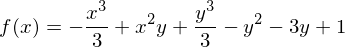

In [20]:
f = x**2 * y - x**3 / 3 +  y**3 / 3 - y**2 - 3 * y + 1 #definiramo našo funkcijo več spremenljivk
f
sym.Eq(funck(x), f)

Podano funkcijo (ki predstavlja neko ukrivljeno porvšino) lahko tudi prikažemo v grafu s pomočjo Matplotlib-a:

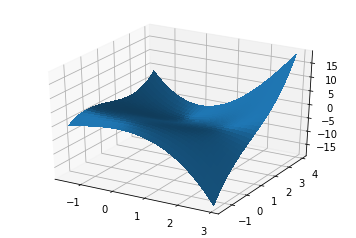

In [21]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Določimo podatke
X = np.arange(-1.5, 3, 0.1)
Y = np.arange(-1.5, 4, 0.1)
X, Y = np.meshgrid(X, Y)
Z = X**2 * Y - X**3 / 3 +  Y**3 / 3 - Y**2 - 3 * Y + 1

# Narišemo površino
surf = ax.plot_surface(X, Y, Z,linewidth=0, antialiased=False)

plt.show()

Stacionarne točke so tiste, v katerih sta oba prva odvoda (torej $\frac{\partial f}{\partial x}$ in $\frac{\partial f}{\partial y}$) enaka 0.
Najprej izračunamo prve odvode:

In [22]:
fx = sym.diff(f, x) #odvod funkcije f po x
fx

In [23]:
fy = sym.diff(f, y) #odvod funkcije f po y
fy

Ker jih bomo potrebovali pozneje, izračunamo tudi druge odvode ($\frac {\partial {f^2}} {\partial^2 x}$, $\frac {\partial {f^2}} {\partial^2 y}$, $\frac {\partial {f^2}} {{\partial x} {\partial y}}$) :

In [24]:
fxx = sym.diff(f, x, x) #drugi odvod funkcije f po x
fxx

In [25]:
fxy = sym.diff(f, x, y) #odvod funkcije f po x, nato po y
fxy

In [26]:
fyy = sym.diff(f, y, y) #drugi odvod funkcije f po y
fyy

Sedaj izračunamo točke, v katerih sta prva odvoda enaka 0:

In [27]:
enacba_1 = sym.Eq(fx, 0)
enacba_1

In [28]:
enacba_2 = sym.Eq(fy, 0)
enacba_2

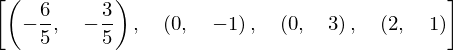

In [29]:
stac_tocke = sym.solve([enacba_1, enacba_2], [x, y]) # s pomočjo Sympy-ja rešimo sistem enačb
stac_tocke

Dobili smo torej 4 točke, ki predstavljajo stacionarne naše funkcije.

In [30]:
T1, T2, T3, T4 = stac_tocke
print('T1 = ',T1)
print('T2 = ',T2)
print('T3 = ',T3)
print('T4 = ',T4)

T1 =  (-6/5, -3/5)
T2 =  (0, -1)
T3 =  (0, 3)
T4 =  (2, 1)


Za klasifikacijo dobljenih točk, je za vsako potrebno izračunati **Hessejevo determinanto**:

$H_f (x_0, y_0) = f_{xx} (x_0, y_0) * f_{yy} (x_0, y_0) - f_{xy} (x_0, y_0) ^2$

Če je $H_f (x_0, y_0) > 0$: ekstrem je!

* Če je $f_{xx} (x_0, y_0) > 0$ je v točki $(x_0, y_0)$ **LOKALNI MINUMUN**
* Če je $f_{xx} (x_0, y_0) < 0$ je v točki $(x_0, y_0)$ **LOKALNI MAKSIMUM**

Če je $H_f (x_0, y_0) < 0$: ekstrema ni! - v točki $(x_0, y_0)$ je **SEDLO**

In [31]:
for tocka in stac_tocke:
    Hf = (fxx*fyy-fxy**2).subs({x:tocka[0], y:tocka[1]}) #izračun Hessejeve det. za dano točko
    if Hf>0:
        if fxx.subs({x:tocka[0], y:tocka[1]}) > 0:
            print(f'Točka {tocka} je LOKALNI MINIMUM.')
        else:
            print(f'Točka {tocka} je LOKALNI MAKSIMUM.')
    else:
        print(f'Točka {tocka} je SEDLO.')

Točka (-6/5, -3/5) je SEDLO.
Točka (0, -1) je LOKALNI MAKSIMUM.
Točka (0, 3) je LOKALNI MINIMUM.
Točka (2, 1) je SEDLO.


# Iskanje ničel

Tema "iskanje ničel" v modulu ni direktno zajeta. Da se naloge navezujejo, bomo poiskali točko, kjer graf funkcije več spremenljivk (iz teme simbolno reševanje) seka tako $x$ kot $y$ os.

Najprej v začetno funkcijo vstavimo $ x = 0$ in tako dobimo funkcijo ene spremenljivke $z=f(y)$

In [32]:
def z(y):
    return y**3 / 3 - y**2 - 3 * y + 1

y = np.linspace(-4, 6, 100) #za katere vrednosti y računamo z

Za boljšo predstavo lahko narišemo graf:

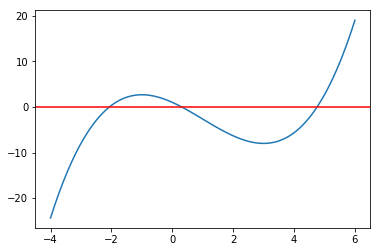

In [33]:
plt.plot(y, z(y))
plt.axhline(color = 'r')
plt.show()

Razvidno je, da ima funkcija $f(y)$ na intervalu $[-4,6]$ 3 ničle. Poiskali jih bomo z vgrajeno $scipy.optimize.bisect$, ki ničle išče s pomočjo bisekcijske metode.

Prva ničla se nahaja na intervalu $[-3,-1]$:

In [34]:
prva = optimize.bisect(z, -3, -1)
prva

Druga ničla se nahaja na intervalu $[0,2]$:

In [35]:
druga = optimize.bisect(z, 0, 2)
druga

Tretja ničla se nahaja na intervalu $[4,6]$:

In [36]:
tretja = optimize.bisect(z, 4, 6)
tretja

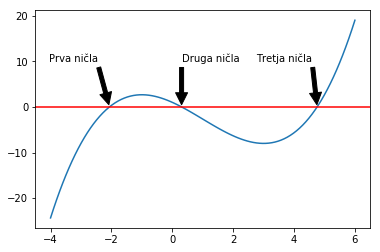

In [37]:
plt.plot(y, z(y))
plt.axhline(color = 'r')
plt.annotate('Prva ničla', xy=(prva, 0), xytext=(prva-2, 10), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Druga ničla', xy=(druga, 0), xytext=(druga, 10), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Tretja ničla', xy=(tretja, 0), xytext=(tretja-2, 10), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# Diferencialne neačbe

V sklopu modula reševanje diferencialnih enačb ni uporabljeno, zato bom to temo pokril s problemom iz elektrotehnike.

NALOGA: Za prikazan sistem določi električne tok, ko stikalo sklenemo.

<img width=500 src="slike/vezava.png">

In [38]:
c = 10**(-5) # F
l = 1 # H
r = 100 # ohm
u0 = 30 # V
t0 = 0 # s
t1 = 0.2 #s

In [39]:
U_0, U_C, U_R, U_L, u, i, t, C, L, R = sym.symbols('U_0, U_C, U_R, U_L, u, i, t, C, L, R') # definiramo potrebne sympy oznake

Nazivna napetost $U_0$ je torej enaka vsoti padcev napetosti na posameznih elementih:

In [40]:
en1 = sym.Eq(U_0, U_C+U_R+U_L)
en1

Iz fizikalnih zakonov lahko zapišemo vrednosti padcev napetosti na posameznih elementih:

In [41]:
U_C = i(t) / C
U_L = L * sym.diff(i(t), t, t)
U_R = R * sym.diff(i(t), t)

Tako dobimo naslednjo **nehomogeno linearno diferencialno enačbo 2. reda**

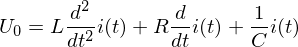

In [42]:
DE = sym.Eq(U_0, U_C+U_R+U_L)
DE

Izpostavimo še najvišji odvod:

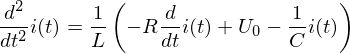

In [43]:
DE_izp = sym.Eq(sym.diff(i(t), t, t), (U_0 - U_R - U_C) /L)
DE_izp

Za rešitev diferencialne enačbe potrebujemo začetne pogoje:

$i(0) = 0$ in  $ \frac{d}{dt} i(0) = 0$

In [44]:
zacetni_pogoji = np.array([0, 0]) # seznam začetnih pogojev

Ker bomo diferencialno enačbo reševali z funkcijo $\textit{scipy.integrate.ode}$, moramo definirati ustrezno funkcijo, ki vrne seznam prvih odvodov ter časovno polje, za katerega iščemo rešitve:

In [45]:
def F_vezje(t, x):
    return np.array([x[1], (-r * x[1] + u0 - x[0]/c)/l])

t, dt = np.linspace(0, t1, 1000, retstep=True) # ustvarimo nove vrednosti, za katere želimo rešitve

Definiramo sezname rešitev $i(t)$ in $ \frac{d}{dt} i(t)$ ter uporabimo vgrajeno metodo za reševanje diferencialne enačbe:

In [46]:
# ustvarimo seznama rešitev diferencialne enačbe (imata 1 element in sicer začetni pogoj)
resitve_i = [zacetni_pogoji[0]]
resitve_di = [zacetni_pogoji[1]]

solver = integrate.ode(F_vezje).set_integrator('vode').set_initial_value(zacetni_pogoji)

while solver.successful() and solver.t < t1:
    solver.integrate(solver.t+dt)
    resitve_i.append(solver.y[0]) # dodamo rešitev i v seznam
    resitve_di.append(solver.y[1]) # dodamo rešitev di v seznam

# sezname pretvorimo v numpy sezname
resitve_i = np.array(resitve_i) 
resitve_di = np.array(resitve_di)

Dobljene rešitve lahko prikažemo še s grafom, ki prikazuje, kako se ob sklenitvi stikala tok spreminja s časom:

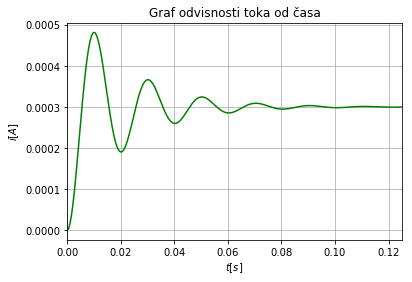

In [47]:
plt.plot(t, resitve_i, 'g')
plt.xlabel('$t [s]$')
plt.ylabel('$i [A]$')
plt.xlim(0, 0.125)
plt.title('Graf odvisnosti toka od časa')
plt.grid()
plt.show()

# Predstavitev delovanja modula

Modul smo že uvozili in iz razreda v njem ustvarili objekt (instanco razreda) "Klemen". Temu smo podali osnovne vhode podatke in pokazali osnovno uporabo. V naslednji celici je predstavljeno logično sosledje, v katerem moramo klicati metodo, da objektu ustrezno določimo vse lastnosi in na koncu napišemo poročilo.

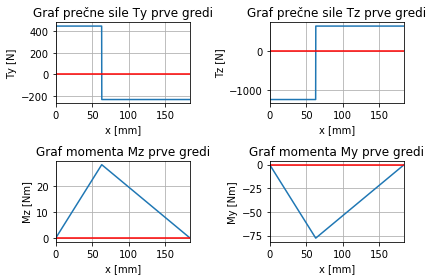

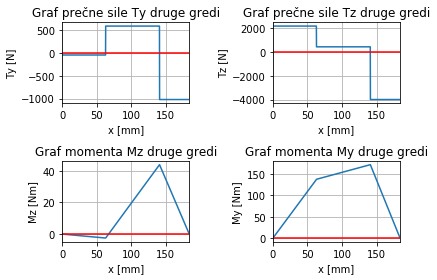

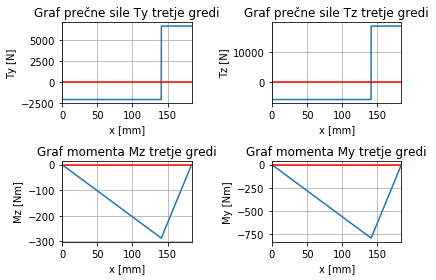

Statična varnost S0 je večja od dovoljene, zato ležaj v podpori A zdrži statično obremenitev.
Statična varnost S0 je večja od dovoljene, zato ležaj v podpori B zdrži statično obremenitev.
Statična varnost S0 je večja od dovoljene, zato ležaj v podpori A zdrži statično obremenitev.
Statična varnost S0 je večja od dovoljene, zato ležaj v podpori B zdrži statično obremenitev.
Statična varnost S0 je večja od dovoljene, zato ležaj v podpori A zdrži statično obremenitev.
Statična varnost S0 je večja od dovoljene, zato ležaj v podpori B zdrži statično obremenitev.


In [48]:
Klemen.psim = 20

# Statika gredi (izrišejo se grafi prečnih sil in momentov v X-Y in X-Z ravnini)
Klemen.statika_gredi_1(l1 = 63, l2 = 78, l3 = 43)
Klemen.statika_gredi_2(l1 = 63, l2 = 78, l3 = 43)
Klemen.statika_gredi_3(l1 = 63, l2 = 78, l3 = 43)

# Statika ležajev
Klemen.lezaji_staticna(gred = 1, fiksen = 'A' , C0={'A':8300, 'B':8300})
Klemen.lezaji_staticna(gred = 2, fiksen = 'A' , C0={'A':14600, 'B':16000})
Klemen.lezaji_staticna(gred = 3, fiksen = 'A' , C0={'A':23200, 'B':23200})

Klemen.lezaji_doba_trajana(gred = 1, fiksen='A', C = {'A':13800, 'B':13800})
Klemen.lezaji_doba_trajana(gred = 2, fiksen='A', C = {'A':22100, 'B':22900})
Klemen.lezaji_doba_trajana(gred = 3, fiksen='A', C = {'A':30700, 'B':30700})

Klemen.lezaji_razsirjena_doba_trajana(gred = 1, T_obr = 80, Cu = {'A':355, 'B':355}, d_lez = {'A':30, 'B':30}, D_lez = {'A':55, 'B':55}, olje = 100)
Klemen.lezaji_razsirjena_doba_trajana(gred = 2, T_obr = 80, Cu = {'A':640, 'B':710}, d_lez = {'A':45, 'B':50}, D_lez = {'A':75, 'B':80}, olje = 1500)
Klemen.lezaji_razsirjena_doba_trajana(gred = 3, T_obr = 80, Cu = {'A':980, 'B':980}, d_lez = {'A':60, 'B':60}, D_lez = {'A':95, 'B':95}, olje = 1500)

# Vrednotenje kritičnih prerezov gredi
Klemen.kriticni_prerezi(gred=1, d_pod_zobnikom=35,Rp02=215, Rm=500, Rmax=4, tab1_st=5, material='S235')
Klemen.kriticni_prerezi(gred=2, d_pod_zobnikom=50,Rp02=215, Rm=500, Rmax=4, tab1_st=5, material='S235', Mf =[137.75, 177.443])
Klemen.kriticni_prerezi(gred=3, d_pod_zobnikom=65,Rp02=215, Rm=500, Rmax=4, tab1_st=5, material='S235')

# Korenska in bočna nosilnost gredi
Klemen.korenska_nosilnost(zveza=12, Yfa=1, Ysa=1, Kfa=1, Kv=1, sigmaflim=250, YRrelT=1, Yx=1)
Klemen.korenska_nosilnost(zveza=34, Yfa=1, Ysa=1, Kfa=1, Kv=1, sigmaflim=250, YRrelT=1, Yx=1)

Klemen.bocna_nosilnost(zveza=12, Zeps=0.75, Kv = 1, sigmahlim = 600, ZX=1)
Klemen.bocna_nosilnost(zveza=34, Zeps=0.75, Kv = 1, sigmahlim = 600, ZX=1)

Prav tako je v modulu zajeta obravnava rezultatov iz laboratorijske vaje. Na kratko se analizo rezultatov naredi na sledeč način:

In [49]:
Klemen.LV_preberi_meritve('podatki_laboratorijska\S01meh.txt')

print('LABORATORISJKA VAJA')
print(f'Delo trenja: {Klemen.LV_Wtr:.1f} J')
print(f'Realna razlika temperatur sklopke: {Klemen.LV_TsklR(22.8, 28.2):.2f} °C')
print(f'Teoretična razlika temperatur sklopke: {Klemen.LV_TsklT(8.3, 460):.2f} °C')
print(f'Maksimalno dovoljeno št. zagonov ob upoštevanju realne razlike T: {Klemen.LV_nzagonov(373)[0]:.0f}')
print(f'Maksimalno dovoljeno št. zagonov ob upoštevanju teoretične razlike T: {Klemen.LV_nzagonov(373)[1]:.0f}')

LABORATORISJKA VAJA
Delo trenja: 63306.3 J
Realna razlika temperatur sklopke: 5.40 °C
Teoretična razlika temperatur sklopke: 16.58 °C
Maksimalno dovoljeno št. zagonov ob upoštevanju realne razlike T: 65
Maksimalno dovoljeno št. zagonov ob upoštevanju teoretične razlike T: 21


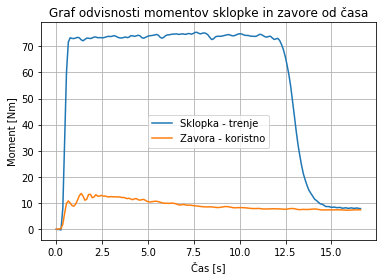

In [50]:
Klemen.LV_graf2() #narišemo lahko naprimer, kako se momenta sklopke in zavore spreminjata s časom

Kot lahko vidimo, moramo metodi podati le pot do datoteke, ki vsebuje meritve, ostalo modul naredi sam.

Zaključek modula omogoča še, da se vse pomembne veličine, izračunane znotraj razreda zapišejo v tekstovno datoteko v obliki poročila in v tabelo excela. Podati moramo le pot, kamor želimo da se ta končna poročila shranijo.

In [51]:
Klemen.zapisi_txt('Porocilo.txt')
Klemen.zapisi_eksel('Slovarji.xlsx')

## Viri

* [1] I. Okorn, J. Klemenc. Strojni elementi 2 - Predloge za vaje
* [2] P. Podržaj. Linearna teorija krmiljenja sistemov
* [3] J. Slavič. Predavanje pri predmetu PiNM